<a href="https://colab.research.google.com/github/hangjoni/food_classifier_project/blob/main/Food_Classifier_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading required libraries

In [ ]:
# loading necessary library
! pip install timm
! [ -e /content ] && pip install -Uqq fastbook
! pip install kaggle

import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 509 kB 6.5 MB/s 
     |████████████████████████████████| 719 kB 15.1 MB/s 
     |████████████████████████████████| 4.7 MB 59.2 MB/s 
     |████████████████████████████████| 365 kB 62.5 MB/s 
     |████████████████████████████████| 1.2 MB 64.8 MB/s 
     |████████████████████████████████| 212 kB 66.0 MB/s 
     |████████████████████████████████| 101 kB 12.3 MB/s 
     |████████████████████████████████| 141 kB 60.5 MB/s 
     |████████████████████████████████| 596 kB 64.4 MB/s 
     |████████████████████████████████| 127 kB 70.3 MB/s 
     |████████████████████████████████| 6.6 MB 60.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatibl

In [ ]:
# establish location for google drive
from google.colab import drive
path = Path('/content/gdrive/MyDrive/food11')

# load saved creds
f = open(path/'kaggle.json', "r")
creds = f.read()

# loading kaggle
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
cred_path.parent.mkdir(exist_ok=True)
cred_path.write_text(creds)
cred_path.chmod(0o600)
from kaggle import *

## Loading data
This is necessary for training. 
Skip if loading pre-trained model

In [ ]:
! kaggle datasets download -d vermaavi/food11 

 99% 2.15G/2.17G [00:22<00:00, 132MB/s]
100% 2.17G/2.17G [00:22<00:00, 105MB/s]


Data is a bit weirdly organized. Unzip will unpack data twice, once in the directory directly, once in food-11 folder

In [ ]:
shutil.unpack_archive('/content/food11.zip')

## Data loader and augmentation
This step needs to be done even if we load a pre-trained model

In [ ]:
def labeller(o):
  f = RegexLabeller(fr'.(\d)_.')
  label_map = {
      '0': "Vegetable-Fruit",
      '1': "Dairy product",
      '2': "Dessert",
      '3': "Egg",
      '4': "Fried food",
      '5': "Meat",
      '6': "Noodles-Pasta",
      '7': "Rice",
      '8': "Seafood",
      '9': "Soup"
  }
  return label_map.get(f(o))

In [ ]:
# define our own custom splitter
from fastcore.foundation import mask2idxs
def _parent_idxs(items, name):
    def _inner(items, name): return mask2idxs(Path(o).parent.name == name for o in items)
    return [i for n in L(name) for i in _inner(items,n)]
def ParentSplitter(train_name='train', valid_name='valid'):
    "Split `items` from the grand parent folder names (`train_name` and `valid_name`)."
    def _inner(o):
        return _parent_idxs(o, train_name),_parent_idxs(o, valid_name)
    return _inner

foods = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=labeller,
    item_tfms=Resize(256), 
    splitter = ParentSplitter(train_name='training', valid_name='validation'))

## Dataloader and Augmentation
Skip these steps if loading pre-trained model

In [ ]:
path = Path('/content/food-11')
dls = foods.dataloaders(path)

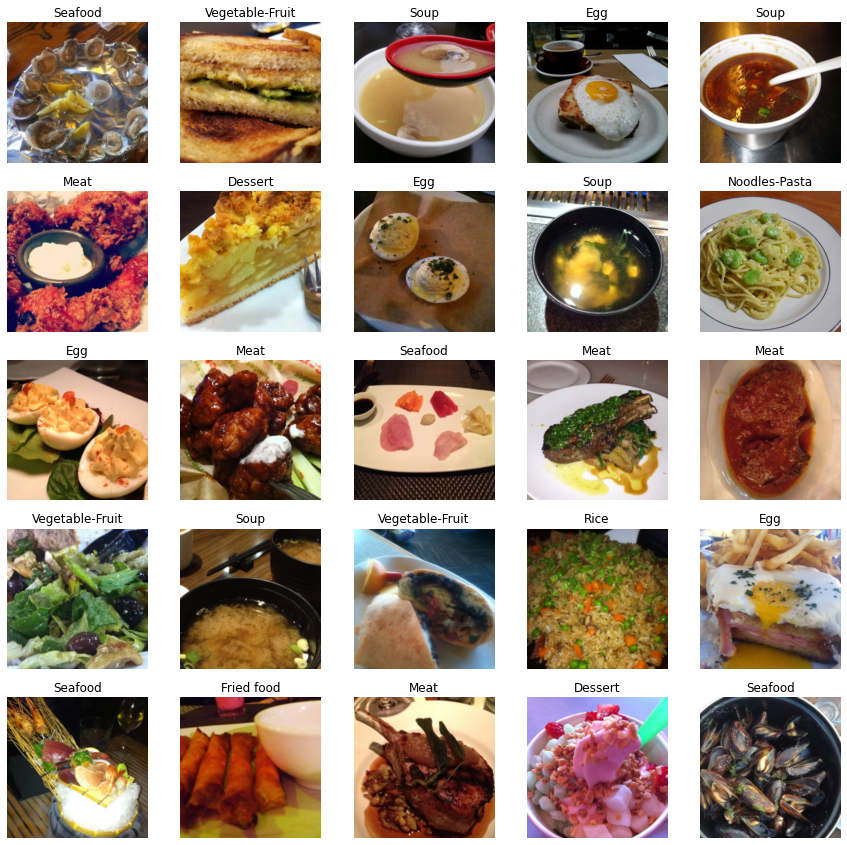

In [ ]:
dls.train.show_batch(max_n=25, nrows=5)

Data Augmentation

Done with testing, now let's combine both of these transforms. 

We'll crop a bit bigger in RandomResizedCrop so that not too much visibility is lost in later aug_transforms

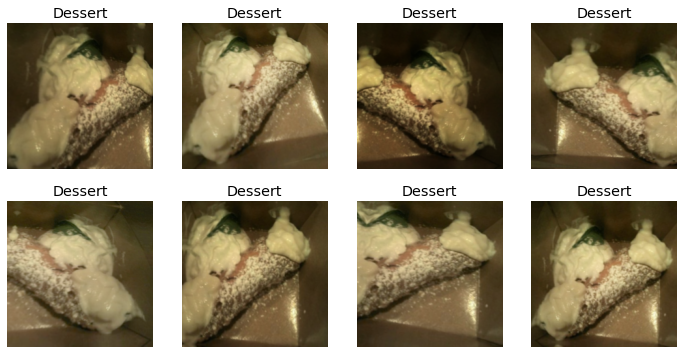

In [ ]:
foods = foods.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = foods.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

The above is not seafood, but can be classified as multiple categories (meat, vegetable, rice)

=> This dataset is not accurately labelled and classes have high overlap

=> Need better labelled dataset
=> Then, need to use multi-category model

# First model
We will use transfer learning using resnet18 as the base model.

Resnet18 is a pre-trained convolutional neural network. It has been trained on more than million immages from ImageNet to recognize 1000 object categories. Using transfer learning, we'll leverage the head of Resnet18 which can recognize lower level image patterns and shape. 

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

9.3% error rate, not very good. 

## Checking top losses

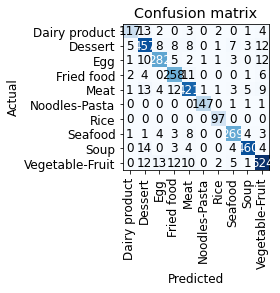

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

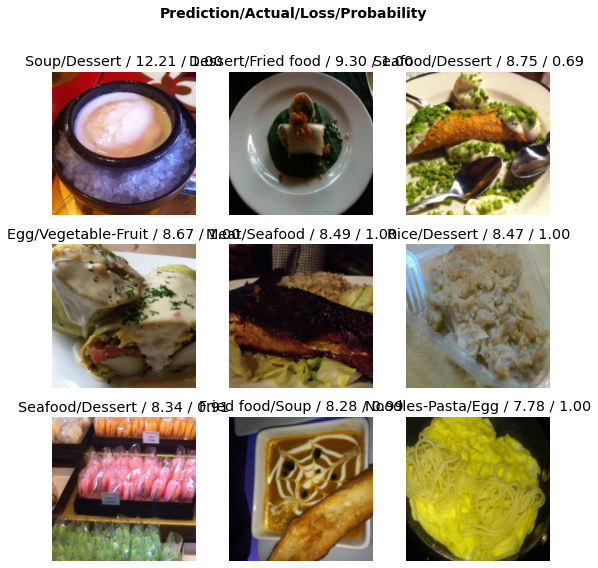

In [ ]:
interp.plot_top_losses(12, nrows=3)

After looking at the top losses, itt seems like labelling problem & multi-class problem as much as a prediction problem

In [ ]:
interp.most_confused(min_val=5)

[('Soup', 'Dessert', 14),
 ('Dairy product', 'Dessert', 13),
 ('Meat', 'Dessert', 13),
 ('Vegetable-Fruit', 'Egg', 13),
 ('Dessert', 'Vegetable-Fruit', 12),
 ('Egg', 'Vegetable-Fruit', 12),
 ('Meat', 'Fried food', 12),
 ('Vegetable-Fruit', 'Dessert', 12),
 ('Vegetable-Fruit', 'Fried food', 12),
 ('Fried food', 'Meat', 11),
 ('Egg', 'Dessert', 10),
 ('Vegetable-Fruit', 'Meat', 10),
 ('Meat', 'Vegetable-Fruit', 9),
 ('Dessert', 'Egg', 8),
 ('Dessert', 'Fried food', 8),
 ('Dessert', 'Meat', 8),
 ('Seafood', 'Meat', 8),
 ('Dessert', 'Seafood', 7),
 ('Fried food', 'Vegetable-Fruit', 6),
 ('Dessert', 'Dairy product', 5),
 ('Egg', 'Fried food', 5),
 ('Meat', 'Soup', 5),
 ('Vegetable-Fruit', 'Seafood', 5)]

Ways to improve our model
- Learning Rate Finder
- Unfreezing and Transfer Learning
- Discriminative Learning Rates
- Selecting the Number of Epochs
- Deeper Archtecture

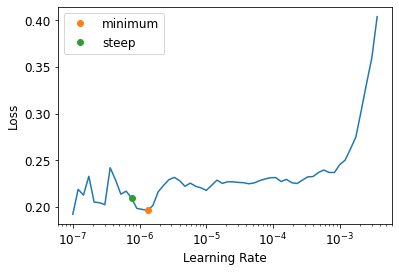

In [ ]:
lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

Let's try to rerun the model with the suggested learning rate

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4, base_lr = 3*10-6)

That's cool. Our error rate has dropped by 1.5% just by picking the learning rate!


In [ ]:
learn.fine_tune??

Turns out, basically fine_tune just do this:
- freeze the last layer in the model
- fit_one_cycle for a few epochs
- unfreeze
- fit_one_cycle again but with differentiated learning rate

Let's try doing this ourself

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.freeze()
learn.fit_one_cycle(3,3e-3)

Then we'll unfreeze the model and find the learning rate

SuggestedLRs(valley=5.248074739938602e-05)

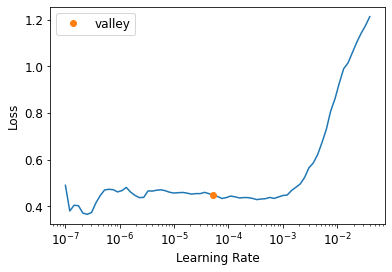

In [ ]:
learn.unfreeze()
learn.lr_find()

We'll then retrain the model with differentiated learning rate

In [ ]:
learn.fit_one_cycle(4, lr_max=(slice(3*1e-6,3*1e-4)))

Our model has gotten worse as compared to just picking learning rate and use the built-in fine-tune.

Let's plot training and validation loss

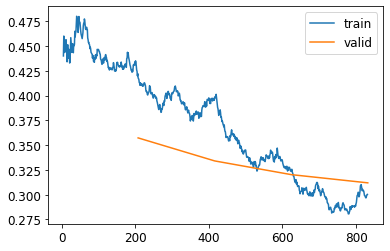

In [ ]:
learn.recorder.plot_loss()

Looks like we have overfit by running for more epochs. We did 3+3 epochs as compared to the learning rate + fine_tune section which did 1+3 epochs

Now let's go back to the previous method and use a deeper model

In [ ]:
from fastai.callback.fp16 import *
learn = vision_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

With a larger model, error rate is pushed down by another 1+%. Our best effort so far at 6.3% error rate

In [ ]:
learn.recorder.plot_loss()


But again, we've overfit towards the last cycle. Let's try again with less epochs

In [ ]:
from fastai.callback.fp16 import *
learn = vision_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(2, freeze_epochs=1)

In [ ]:
learn.recorder.plot_loss()

# Save and use pre-trained model

In [ ]:
# Export model 
from google.colab import drive
drive.mount('/content/drive')

learn.export('/content/drive//MyDrive/export.pkl')

In [ ]:
# Load pre-trained model
learn_inf = load_learner('/content/drive/MyDrive/food11/export.pkl')

# Multi-category Labelling Model
As we seen above, some of the food images contain elements that belong to different categories. For example, an apple pie image with an apple next to the pie could be categorized as Dessert or Fruit. Ideally, it should be categorized as both.

There are two directions we could explore:
  
1.   With the existing model, we could return the top 3 categories with highest activation
2.   We build a new model for Multi Category Labelling task 





###1. Return top 3 categories

In [ ]:
res = learn_inf.predict('/content/drive/MyDrive/food11/pho-quay.jpeg')
res

('Fried food',
 TensorBase(3),
 TensorBase([4.1440e-05, 2.2627e-05, 1.4859e-05, 8.1437e-01, 3.4734e-03, 7.9870e-04, 3.7404e-03, 1.7275e-01, 2.7538e-04, 4.5173e-03]))

In [ ]:
def predict_3_cat(learn, img):
  res = learn.predict(img)
  idxs = torch.topk(res[2], 3)
  
  dl = learn.dls.test_dl([img], num_workers=0)
  inp,preds,_,dec_preds = learn.get_preds(dl=dl, with_input=True, with_decoded=True)
  i = getattr(learn.dls, 'n_inp', -1)
  inp = (inp,) if i==1 else tuplify(inp)
  b = inp + tuplify(dec_preds)
  input = batch_to_samples(b, max_n=9)

  f1 = learn_inf.dls.before_batch.decode
  f = learn_inf.dls.after_item.decode
  ff = compose(f1, f, partial(getattr(learn_inf.dls.dataset,'decode',noop), full = True))

  r = []
  for j, k in zip(idxs[0], idxs[1]):
    i = tuple(list([input[0][0],k]))
    input[0] = i
    r.append((input.map(ff)[0][1], j))
  return r

In [ ]:
img = '/content/drive/MyDrive/food11/pho-quay.jpeg'
a = predict_3_cat(learn_inf, img)
a

[('Fried food', TensorBase(0.8144)),
 ('Seafood', TensorBase(0.1727)),
 ('Vegetable-Fruit', TensorBase(0.0045))]

Huh food-11 has 10 categories? I just realized haha. This dataset seems increasingly questionable 

###2. Multi-category label
The issue is our dataset is labelled using only single category. How do we make this work?

#### Building our multi-category model

In [ ]:
learn = vision_learner(dls, resnet18)

In [ ]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
  if sigmoid: inp = inp.sigmoid()
  return((inp>thresh)==targ.bool()).float().mean()

In [ ]:
def labeller(o):
  f = RegexLabeller(fr'(\d)_.')

  label_map = {
      '0': "Vegetable-Fruit",
      '1': "Dairy product",
      '2': "Dessert",
      '3': "Egg",
      '4': "Fried food",
      '5': "Meat",
      '6': "Noodles-Pasta",
      '7': "Rice",
      '8': "Seafood",
      '9': "Soup"
  }

  return [label_map.get(f(o))]

foods = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_items=get_image_files,
    get_y=labeller,
    item_tfms=Resize(256)
)

In [ ]:
path = Path('/content/food-11')
dls = foods.dataloaders(path)

In [ ]:
learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.1))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Save the model for future use

In [ ]:
learn.export('/content/drive/MyDrive/food11/multicat-model.pkl')

#### Testing multi-category model

In [ ]:

from google.colab import drive
drive.mount('/content/drive')
res = learn.predict('/content/drive/MyDrive/food11/pho-quay.jpeg')
res

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


((#1) ['Fried food'],
 TensorBase([False, False, False,  True, False, False, False, False, False, False]),
 TensorBase([4.6776e-05, 3.3333e-04, 7.4197e-05, 5.2091e-01, 8.2296e-04, 1.3750e-03, 2.1808e-04, 2.3181e-01, 1.2685e-02, 1.4622e-03]))

In [ ]:
res = learn.predict('/content/drive/MyDrive/food11/chao-quay.jpeg')
res

((#1) ['Soup'],
 TensorBase([False, False, False, False, False, False, False, False,  True, False]),
 TensorBase([1.3266e-05, 3.0630e-03, 2.1829e-04, 4.3742e-01, 6.6988e-05, 5.4721e-05, 6.1935e-04, 8.7297e-04, 9.4048e-01, 5.7319e-05]))

In [ ]:
res = learn.predict('/content/drive/MyDrive/food11/applepie2.jpeg')
res

((#1) ['Dessert'],
 TensorBase([False,  True, False, False, False, False, False, False, False, False]),
 TensorBase([4.5677e-04, 7.2671e-01, 7.2844e-02, 3.7986e-02, 2.8392e-03, 5.0463e-04, 1.2401e-03, 3.1909e-04, 2.7521e-04, 4.5982e-03]))

In [ ]:
res = learn.predict('/content/drive/MyDrive/food11/applepie5.jpeg')
res

((#1) ['Dessert'],
 TensorBase([False,  True, False, False, False, False, False, False, False, False]),
 TensorBase([2.8932e-05, 9.4535e-01, 1.5580e-02, 4.3675e-02, 8.8171e-04, 2.1217e-04, 1.0401e-04, 2.4795e-04, 2.5661e-04, 1.3151e-03]))

#### Which threshold to use

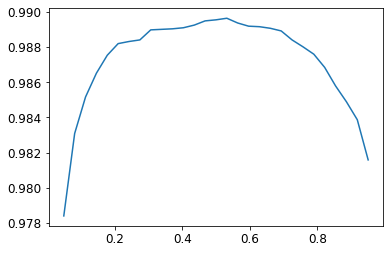

In [ ]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

Our multi category model which was trained on single label still return largely just 1 label

#### Test model on non relevant image
With multiple category model, we hope that one benefit is that the model will not force itself to choose from one of the category. Instead, when given non-food images, we expect the model to be able to say: "Nope, there's no chance this is one of the food categories I'm trained to recognize!"

Well let's see. But first, we need to load our previously saved model.

In [ ]:
multi_inf = load_learner('/content/gdrive/MyDrive/food11/multicat-model.pkl')

In [ ]:
multi_inf.predict('/content/gdrive/MyDrive/food11/grizzly.jpeg')

((#1) ['Meat'],
 TensorBase([False, False, False, False,  True, False, False, False, False, False]),
 TensorBase([1.0301e-02, 2.3329e-01, 5.1406e-03, 5.5430e-03, 6.0496e-01, 4.1444e-04, 3.0896e-04, 3.4687e-02, 2.1218e-03, 1.1991e-02]))

In [ ]:
multi_inf.predict('/content/gdrive/MyDrive/food11/cat3.jpeg')

((#0) [],
 TensorBase([False, False, False, False, False, False, False, False, False, False]),
 TensorBase([3.1473e-02, 8.7221e-02, 7.6809e-02, 7.4189e-05, 1.4409e-05, 8.3247e-05, 2.4533e-04, 6.1729e-06, 3.8966e-04, 2.1989e-02]))

In [ ]:
multi_inf.predict('/content/gdrive/MyDrive/food11/cat1.png')

((#0) [],
 TensorBase([False, False, False, False, False, False, False, False, False, False]),
 TensorBase([6.9616e-03, 2.1806e-01, 2.0770e-05, 1.7078e-05, 5.1980e-05, 8.1831e-04, 4.1387e-04, 1.0424e-01, 5.3570e-04, 1.4883e-02]))

In [ ]:
multi_inf.predict('/content/gdrive/MyDrive/food11/grizzlybear.jpeg')

((#0) [],
 TensorBase([False, False, False, False, False, False, False, False, False, False]),
 TensorBase([0.0901, 0.3419, 0.0135, 0.0028, 0.0573, 0.0010, 0.0004, 0.0172, 0.0122, 0.1310]))

So our model does pretty well on non food photos. Except for the low resolution bear photo. This can probably be improved further if we increase the threshold to 0.5 instead of 0.1 currently

# Food *101*

## Data downloads

In [ ]:
food101 = untar_data("http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz")

In [ ]:
food101

Path('/root/.fastai/data/food-101')

In [ ]:
food101 = Path('/root/.fastai/data/food-101')

In [ ]:
food101.ls()

(#4) [Path('/root/.fastai/data/food-101/license_agreement.txt'),Path('/root/.fastai/data/food-101/images'),Path('/root/.fastai/data/food-101/meta'),Path('/root/.fastai/data/food-101/README.txt')]

In [ ]:
f = food101/'images'
f.ls()

(#101) [Path('/root/.fastai/data/food-101/images/escargots'),Path('/root/.fastai/data/food-101/images/shrimp_and_grits'),Path('/root/.fastai/data/food-101/images/chocolate_mousse'),Path('/root/.fastai/data/food-101/images/lobster_bisque'),Path('/root/.fastai/data/food-101/images/ice_cream'),Path('/root/.fastai/data/food-101/images/beet_salad'),Path('/root/.fastai/data/food-101/images/takoyaki'),Path('/root/.fastai/data/food-101/images/dumplings'),Path('/root/.fastai/data/food-101/images/edamame'),Path('/root/.fastai/data/food-101/images/risotto')...]

In [ ]:
def labeller(o):
  f = RegexLabeller(fr'./(\w+)/\d+.jpg$')
  return f(o)

(512, 289)


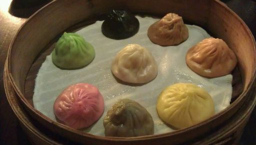

In [ ]:
dumplings = get_image_files(f/'dumplings')
img = PILImage.create(dumplings[0])
print(img.size)
img.to_thumb(256)

In [ ]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, dumplings, n_workers=8)
pd.Series(sizes).value_counts()

(512, 512)    571
(512, 384)    179
(384, 512)     68
(512, 382)     28
(382, 512)     25
(512, 341)     20
(511, 512)     11
(512, 288)     10
(512, 342)      8
(512, 383)      7
(512, 289)      5
(512, 306)      5
(306, 512)      5
(341, 512)      4
(512, 343)      3
(512, 340)      3
(308, 512)      2
(512, 410)      2
(512, 339)      2
(512, 471)      2
(512, 308)      2
(512, 503)      2
(512, 511)      2
(512, 379)      2
(512, 465)      1
(383, 512)      1
(512, 287)      1
(512, 434)      1
(506, 512)      1
(512, 413)      1
(389, 512)      1
(512, 368)      1
(512, 385)      1
(512, 370)      1
(512, 510)      1
(507, 512)      1
(445, 512)      1
(512, 400)      1
(512, 420)      1
(512, 509)      1
(340, 512)      1
(512, 307)      1
(512, 478)      1
(512, 459)      1
(512, 362)      1
(512, 479)      1
(512, 369)      1
(365, 512)      1
(512, 506)      1
(403, 512)      1
(512, 489)      1
(512, 417)      1
(512, 304)      1
(512, 380)      1
(289, 512)      1
(512, 496)

## Resnet 18

### Dataloaders

In [ ]:
foods = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=labeller,
    item_tfms=Resize(256))

We haven't done any form of data augmentation!

In [ ]:
dls = foods.dataloaders(food101)

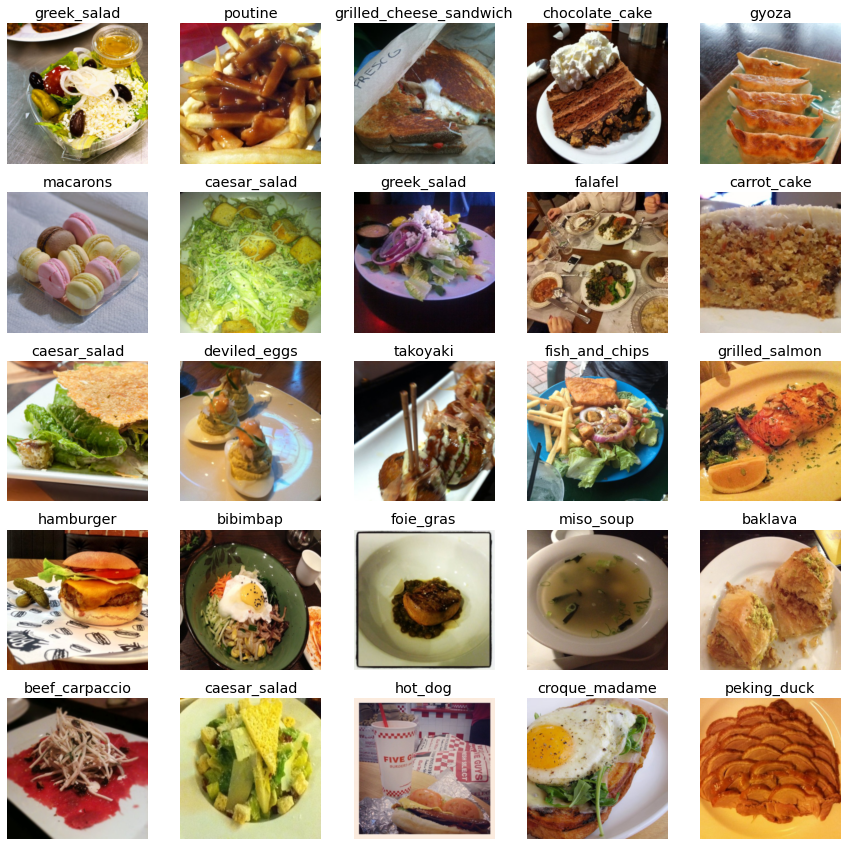

In [ ]:
dls.train.show_batch(max_n=25, nrows=5)

In [ ]:
dls.train.vocab

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

### Model Training

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

The error rate looks pretty bad here albeit improving. Maybe this is not a good enough architecture

In [ ]:
learn.export('/content/drive/MyDrive/food11/food101-one-label-model.pkl')

## Tensorflow foodd trained on BIT-m R50x1

However this model was pretrained on Keras / Tensorflow so we can't load it to fastai for finetuning. Right?

https://tfhub.dev/google/experts/bit/r50x1/in21k/food/1

## A new model

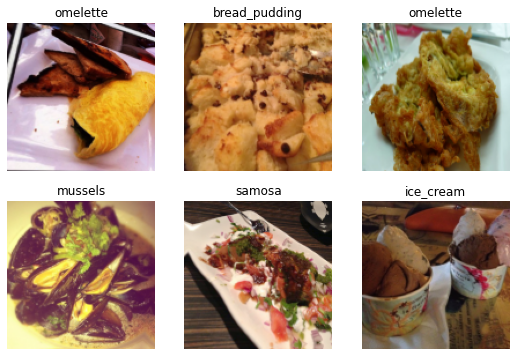

In [ ]:
foods = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=labeller,
    item_tfms=Resize(256, method='squish'),
    batch_tfms = aug_transforms(size=128, min_scale=0.75))

dls = foods.dataloaders(food101)
dls.show_batch(max_n=6)

In [ ]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate).to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet26d-69e92c46.pth" to /root/.cache/torch/hub/checkpoints/resnet26d-69e92c46.pth


SuggestedLRs(valley=0.0010000000474974513, slide=9.120108734350652e-05)

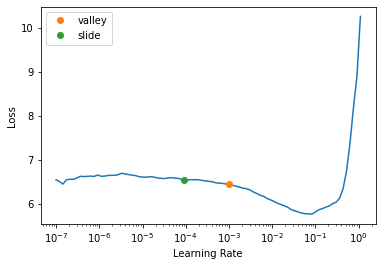

In [ ]:
learn.lr_find(suggest_funcs=(valley, slide))

In [ ]:
learn.fine_tune(3, 0.01)

still very high error rate

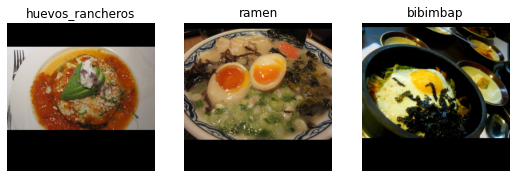

In [ ]:
foods = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=labeller,
    item_tfms=Resize(480, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros))

dls = foods.dataloaders(food101)
dls.show_batch(max_n=3)

In [ ]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate).to_fp16()

SuggestedLRs(valley=0.0012022644514217973, slide=0.002511886414140463)

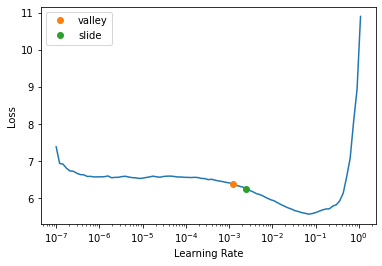

In [ ]:
learn.lr_find(suggest_funcs=(valley, slide))

In [ ]:
learn.fine_tune(5, 0.05)

That took way too long! and looks like vanishing gradient?


In [ ]:
learn.export('/content/drive/MyDrive/food11/food101-resnet26d-pointoo5lr.pkl')

In [ ]:
learn.fine_tune(5, 0.01)

In [ ]:
learn.export('/content/drive/MyDrive/food11/food101-resnet26d-pointo1lr.pkl')

In [ ]:
learn.fine_tune(5, 0.0025)

In [ ]:
learn.export('/content/drive/MyDrive/food11/food101-resnet26d-pointo025lr.pkl')

# Visualize features

In [ ]:
learn = load_learner('/content/drive/MyDrive/food11/food101-one-label-model.pkl')

## CAM Heatmap

In [ ]:
learn.predict('/content/drive/MyDrive/food11/applepie5.jpeg')

('waffles',
 TensorBase(100),
 TensorBase([8.0148e-02, 9.3349e-05, 6.5560e-04, 1.0746e-05, 9.5083e-05, 8.5922e-06, 2.7389e-06, 6.5505e-06, 1.8360e-04, 2.5504e-05, 1.6626e-04, 6.3557e-06, 3.3499e-05, 1.8580e-06, 8.8900e-04,
             1.5275e-06, 5.5977e-05, 1.3155e-03, 1.0557e-06, 4.0753e-05, 1.3536e-06, 9.7028e-04, 2.4127e-04, 4.0922e-05, 2.1271e-06, 1.6903e-05, 3.2545e-06, 9.7827e-04, 3.2487e-04, 2.6599e-04,
             1.0323e-05, 8.0892e-04, 3.7503e-06, 1.9840e-06, 6.1956e-05, 7.3816e-05, 1.5079e-06, 1.5007e-05, 1.3365e-05, 3.0624e-04, 1.5362e-04, 3.6395e-05, 1.3444e-03, 5.1412e-06, 1.7037e-04,
             1.7615e-05, 2.0537e-04, 4.2713e-05, 1.3069e-06, 2.8096e-04, 3.5892e-04, 1.3802e-06, 1.2791e-06, 3.3369e-05, 5.6187e-06, 3.6641e-04, 7.1251e-05, 2.5383e-06, 7.5510e-06, 5.6070e-05,
             7.8556e-06, 2.6695e-05, 8.5155e-04, 1.5649e-04, 1.4183e-06, 4.7754e-05, 1.6763e-05, 3.9333e-04, 5.3818e-05, 3.1856e-06, 2.5701e-04, 2.1566e-03, 1.2731e-03, 1.0373e-05, 2.0342e-06,
     

In [ ]:
img = PILImage.create(path/'applepie5.jpeg')
x, = first(dls.test_dl([img]))

In [ ]:
class Hook():
  def hook_func(self, m, i, o): self.stored = o.detach().clone()

In [ ]:
hook_output = Hook()
hook = learn.model[0].register_forward_hook(hook_output.hook_func)

In [ ]:
learn.model.cuda()
with torch.no_grad(): output = learn.model.eval()(x)

In [ ]:
output

TensorBase([[ 8.4716,  0.6656,  2.7900,  2.0608,  1.2338, -1.0533, -1.5639, -1.9569,  3.3367, -1.0192,  1.3544,  1.2367,  0.9206, -2.0541,  4.2906, -2.9788,  4.5874,  7.2889, -0.1298,  2.2217,
             -1.7846,  2.3750,  3.0759, -0.2059,  0.2588, -0.9010, -0.7780,  3.6660,  0.1601,  2.6435, -0.0684,  2.9653, -0.6091, -3.0744, -0.5106,  1.3092,  0.6059, -0.7180,  0.7241,  3.6823,
              0.3230,  0.0780,  2.0405, -0.8154,  3.2169,  1.3151,  0.9179,  2.3267, -0.8847,  0.8610,  0.5142, -0.3966, -2.2615, -0.7905, -0.3225,  2.2542,  2.4783,  1.6858,  0.7197,  0.0449,
              0.0344, -2.3897,  3.1434,  0.1213, -0.5110, -1.1347,  1.6675,  3.5095,  1.9114, -0.7740,  1.0892,  1.2546,  5.0022,  2.1413,  0.9105, -2.1100,  3.3899,  0.8133,  0.4861, -1.3926,
              0.0431, -1.6205,  1.5948,  1.7726,  4.0356, -1.3669, -0.4051,  0.6843, -2.5692, -0.2315,  2.4822,  2.6969, -4.8367,  0.4386,  4.1832, -0.6078, -0.1021, -2.8273,  3.0174, -0.5047,
              9.7622]], device='cud

In [ ]:
act = hook_output.stored[0]

In [ ]:
F.softmax(output, dim=-1)

TensorBase([[1.9446e-01, 7.9201e-05, 6.6275e-04, 3.1964e-04, 1.3980e-04, 1.4197e-05, 8.5205e-06, 5.7517e-06, 1.1450e-03, 1.4691e-05, 1.5772e-04, 1.4020e-04, 1.0221e-04, 5.2191e-06, 2.9721e-03,
             2.0702e-06, 3.9991e-03, 5.9595e-02, 3.5752e-05, 3.7544e-04, 6.8332e-06, 4.3766e-04, 8.8213e-04, 3.3132e-05, 5.2730e-05, 1.6534e-05, 1.8697e-05, 1.5914e-03, 4.7776e-05, 5.7246e-04,
             3.8016e-05, 7.8972e-04, 2.2138e-05, 1.8814e-06, 2.4430e-05, 1.5075e-04, 7.4612e-05, 1.9855e-05, 8.3970e-05, 1.6176e-03, 5.6230e-05, 4.4009e-05, 3.1321e-04, 1.8011e-05, 1.0157e-03,
             1.5164e-04, 1.0194e-04, 4.1701e-04, 1.6805e-05, 9.6294e-05, 6.8072e-05, 2.7381e-05, 4.2413e-06, 1.8466e-05, 2.9485e-05, 3.8783e-04, 4.8527e-04, 2.1969e-04, 8.3608e-05, 4.2575e-05,
             4.2132e-05, 3.7313e-06, 9.4367e-04, 4.5959e-05, 2.4420e-05, 1.3089e-05, 2.1571e-04, 1.3609e-03, 2.7528e-04, 1.8773e-05, 1.2098e-04, 1.4274e-04, 6.0546e-03, 3.4643e-04, 1.0118e-04,
             4.9353e-06, 1.2075e-03

In [ ]:
x.shape

torch.Size([1, 3, 256, 256])

In [ ]:
F.softmax(output, dim=-1).argmax()

TensorBase(100, device='cuda:0')

In [ ]:
dls.vocab[100]

'waffles'

In [ ]:
learn.model[1][-1].weight.shape, act.shape

(torch.Size([101, 512]), torch.Size([512, 8, 8]))

In [ ]:
cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
cam_map.shape

torch.Size([101, 8, 8])

This is CAM map for waffles activation

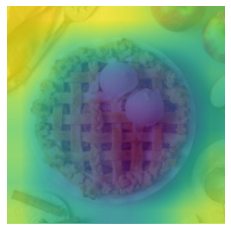

In [ ]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_, ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map[100].detach().cpu(), alpha=0.8, extent=(0, 256, 256, 0),
          interpolation='bilinear', cmap='viridis')

This is CAM map for apple pie activation

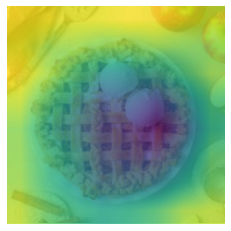

In [ ]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_, ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map[0].detach().cpu(), alpha=0.8, extent=(0, 256, 256, 0),
          interpolation='bilinear', cmap='viridis')

Seems like the model mostly pick up from the rear background of the image. It fails to account for the most important parts of the image

In [ ]:
hook.remove()

In [ ]:
class Hook():
  def __init__(self, m):
    self.hook = m.register_forward_hook(self.hook_func)
  def hook_func(self, m, i, o): self.stored = o.detach().clone()
  def __enter__(self, *args): return self
  def __exit__(self, *args): self.hook.remove()

In [ ]:
with Hook(learn.model[0]) as hook:
  with torch.no_grad(): output = learn.model.eval()(x.cuda())
  act = hook.stored

## Gradient CAM

In [ ]:
class HookBwd():
  def __init__(self, m):
    self.hook = m.register_backward_hook(self.hook_func)
  def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
  def __enter__(self, *args): return self
  def __exit__(self, *args): self.hook.remove()

### Apple pie CAM grad

In [ ]:
cls = 100
with HookBwd(learn.model[0]) as hookg:
  with Hook(learn.model[0]) as hook:
    output = learn.model.eval()(x.cuda())
    act = hook.stored
  output[0, cls].backward()
  grad = hookg.stored

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [ ]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

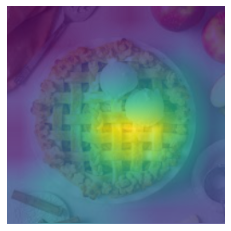

In [ ]:
_, ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.8, extent=(0, 256, 256, 0),
                               interpolation='bilinear', cmap='viridis')

#### Second to last ResNet group

In [ ]:
with HookBwd(learn.model[0][-5]) as hookg:
  with Hook(learn.model[0][-5]) as hook:
    output = learn.model.eval()(x.cuda())
    act = hook.stored
  output[0,cls].backward()
  grad = hookg.stored

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [ ]:
w = grad[0].mean(dim=[1,2], keepdim=True)
camp_map = (w * act[0]).sum(0)

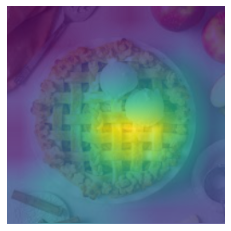

In [ ]:
_, ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.8, extent=(0, 256, 256, 0),
          interpolation='bilinear', cmap='viridis')

Something is wrong with our model. The grad looks the same no matter which gradient we view

Apple pie CAM grad

In [ ]:
cls = 0
with HookBwd(learn.model[0]) as hookg:
  with Hook(learn.model[0]) as hook:
    output = learn.model.eval()(x.cuda())
    act = hook.stored
  output[0, cls].backward()
  grad = hookg.stored

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [ ]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

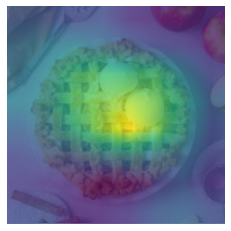

In [ ]:
_, ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.8, extent=(0, 256, 256, 0),
                               interpolation='bilinear', cmap='viridis')

Second to last ResNet group

In [ ]:
with HookBwd